In [36]:
from astroquery.gaia import Gaia
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [37]:
def query2df(query):
    try:
        job = Gaia.launch_job(query)
        result = job.get_results()
        df = Table.to_pandas(result)
        return df
    except Exception as e:
        print(f"Error executing query: {e}")
        return None

In [41]:

from astropy.coordinates import SkyCoord
from astropy import units as u
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from astropy.table import Table

# Define the search region (RA=280, Dec=-60) and radius (0.1 degrees)
ra = 280  # degrees
dec = -60  # degrees
coord = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
radius = 0.1 * u.deg

# Query Gaia catalog
query = f"""
SELECT TOP 10000
source_id, ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE CONTAINS(POINT('ICRS', ra, dec), CIRCLE('ICRS', {ra}, {dec}, {radius.to(u.deg).value}))=1
"""
job = Gaia.launch_job(query)
gaia_data = job.get_results()

# Convert Gaia data to pandas DataFrame for clustering
data = Table.to_pandas(gaia_data)

# Extract RA, Dec, and Magnitude for clustering
X = data[['ra', 'dec']].values  # Only using RA and Dec for clustering

# Normalize the data (optional, can improve clustering performance)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN clustering (Density-Based Spatial Clustering)
dbscan = DBSCAN(eps=0.05, min_samples=10)  # Adjust eps and min_samples as needed
clusters = dbscan.fit_predict(X_scaled)

# Add cluster labels to the data
data['cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(data['ra'], data['dec'], c=data['cluster'], cmap='viridis', s=5, label='Stars')
plt.xlabel('RA (J2000)')
plt.ylabel('Dec (J2000)')
plt.title(f'Star Clustering in 0.1-degree Square around RA=280, Dec=-60')
plt.gca().invert_xaxis()  # Invert RA axis
plt.colorbar(label='Cluster ID')
plt.grid(True)
plt.show()


TimeoutError: [WinError 10060] A connection attempt failed because the connected party did not properly respond after a period of time, or established connection failed because connected host has failed to respond

In [39]:
def plot_clusters(data, cluster_labels, ra_column='ra', dec_column='dec', title='Star Clustering'):
    """
    Plots all stars and draws circles around the identified clusters.
    
    Parameters:
    - data: Pandas DataFrame containing the star data (RA, Dec, and clusters)
    - cluster_labels: Array of cluster labels corresponding to each star
    - ra_column: Column name for Right Ascension in the DataFrame
    - dec_column: Column name for Declination in the DataFrame
    - title: Title of the plot
    """
    plt.figure(figsize=(10, 8))
    
    # Plot all stars, coloring them based on their cluster labels
    scatter = plt.scatter(data[ra_column], data[dec_column], c=cluster_labels, cmap='viridis', s=5, label='Stars')
    
    # Invert x-axis for RA
    plt.gca().invert_xaxis()
    
    # Adding labels and title
    plt.xlabel('RA (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(title)
    plt.colorbar(scatter, label='Cluster ID')

    # Draw circles around clusters
    unique_clusters = np.unique(cluster_labels)
    
    for cluster_id in unique_clusters:
        if cluster_id == -1:  # Skip noise points
            continue
            
        # Get points belonging to this cluster
        cluster_points = data[cluster_labels == cluster_id]
        if len(cluster_points) > 1:
            # Calculate the centroid of the cluster
            ra_centroid = cluster_points[ra_column].mean()
            dec_centroid = cluster_points[dec_column].mean()
            
            # Calculate the radius (max distance from centroid to points in the cluster)
            distances = np.sqrt((cluster_points[ra_column] - ra_centroid)**2 +
                                (cluster_points[dec_column] - dec_centroid)**2)
            radius = distances.max()
            
            # Draw a circle around the cluster
            circle = plt.Circle((ra_centroid, dec_centroid), radius, color='red', fill=False, lw=1.5)
            plt.gca().add_artist(circle)

    plt.grid(True)
    plt.show()

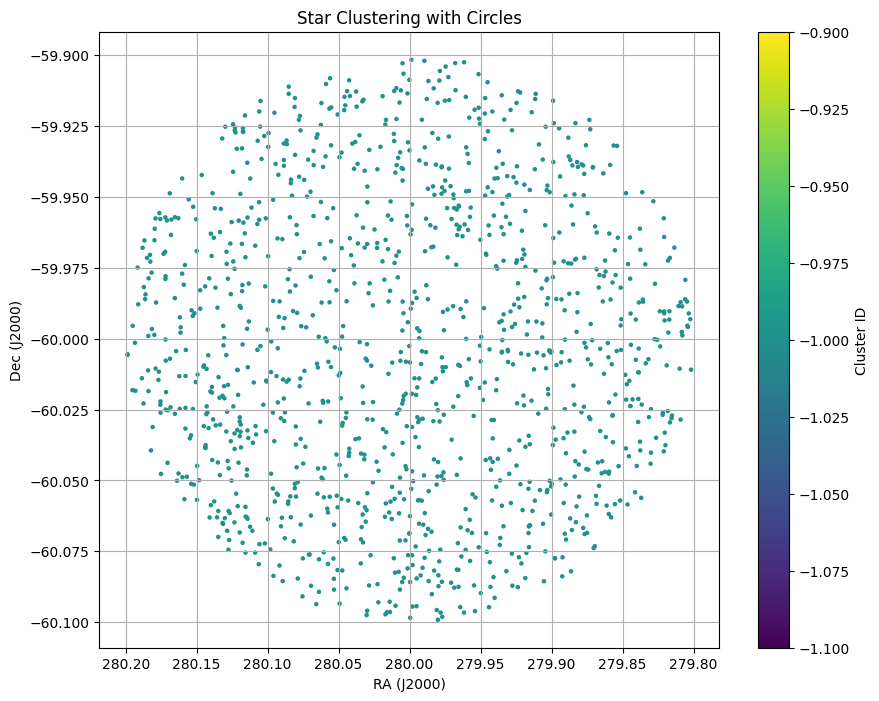

In [40]:
# Assuming 'data' is your DataFrame and 'clusters' is the array of cluster labels
plot_clusters(data, clusters, ra_column='ra', dec_column='dec', title='Star Clustering with Circles')